# Project 1 - Emission line
---
## Sparsha Ray (MS21256)
#### PHY669 (Astrophysics Techniques 2025 Spring)

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
from astropy.io      import fits
from scipy.special   import factorial
from scipy.optimize  import curve_fit                                # For fitting guassians to the emission lines
from scipy.signal    import savgol_filter, find_peaks as peakfind    # To help in finding the peaks in the spectrum, not strictly necessary
from glob            import glob                                     # For file handling

import warnings; warnings.filterwarnings('ignore')                   # To suppress the warnings from curve_fit


# --- ! Class sepecat to handle the fits file and processes all the data --- :
class sepecat :

    def __init__(self, path, debug=False) : 
        self.path = path            # path to fits file
        self.hdu = fits.open(path)  # open the fits file
        assert len(self.hdu) == 1 , 'The file contains multiple HDUs'
        self.debug = debug          # whether to show plots for the subroutines


# 1st step : extract the data from the fits file --------------------------------------

    def extract_data(self) : 

        '''
        Extracts the spectrum and the headers from the fits file.
        Reconstructs the wavelength array from the header information.
        If the necessary header information is not found, a ValueError is raised.
        '''
        
        self.spec = self.hdu[0].data
        self.header = self.hdu[0].header

        try :
            idx = self.header['CRPIX1'] - 1
            idx_wavelength = self.header['CRVAL1']
            incr = self.header['CDELT1']
            data_points = self.header['NAXIS1']
        except :
            raise ValueError('The header does not contain the necessary information')        

        self.wavelengths = idx_wavelength + (np.arange(data_points) - idx) * incr

        if self.debug :
            plt.plot(self.wavelengths, self.spec)
            plt.title('Raw Spectrum')
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
            plt.grid()
            plt.show()


# 2nd step : redding correction -------------------------------------------------------

    def reddening_correction(self, R_v=3.1, EBV=0.0889) :

        '''
        Corrects the spectrum for reddening using the reddening law found in P. W. A. Roming et. al. (2009)
        E(B-V) value is from https://irsa.ipac.caltech.edu/applications/DUST/
        '''

        wavelengths = self.wavelengths / 1E4 # convert to microns
        wavenumber = 1 / wavelengths
        y = wavenumber - 1.82
        a = 1 + 0.17699*y - 0.50447*y**2 - 0.02427*y**3 + 0.72085*y**4 + 0.01979*y**5 - 0.77530*y**6 + 0.32999*y**7
        b = 0 + 1.41338*y + 2.28305*y**2 + 1.07233*y**3 - 5.38434*y**4 - 0.62251*y**5 + 5.30260*y**6 - 2.09002*y**7

        A_l = EBV * (a * R_v + b)
        flux_ratio = 10 ** (0.4 * A_l)
        flux_dereddened = self.spec * flux_ratio
        self.flux = flux_dereddened

        if self.debug :
            plt.plot(self.wavelengths, self.flux)
            plt.title('Reddening Corrected Spectrum')
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
            plt.grid()
            plt.show()

    
# 3rd step : mask the emission lines before fitting power law --------------------------

    def mask_emission_lines(self, wavelength_ranges=[(5000, 5500), (6750, 8000)]) :

        '''
        Masks the large emission lines and the strong atmospheric absorbtion lines in the spectrum before fitting the power law.
        The wavelength ranges to be masked are passed as a list of tuples.
        '''

        mask = np.zeros_like(self.wavelengths, dtype=bool)
        for wavelength_range in wavelength_ranges :
            template = np.logical_and(self.wavelengths > wavelength_range[0], self.wavelengths < wavelength_range[1])
            mask = np.logical_or(template, mask)

        self.masked_flux = np.delete(self.flux, mask)
        self.masked_wavelengths = np.delete(self.wavelengths, mask)

        if self.debug :
            plt.plot(self.masked_wavelengths, self.masked_flux, 'b.')
            plt.title('Masked Spectrum for Power Law Fit')
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
            plt.grid()
            plt.show()


# 4th step : subtract the baseline using power law fit ---------------------------------

    # The poission distribution log likelihood for powerlaw trend
    def log_likelihood(self, c, a, x, y) :

        '''
        Calculates the log likelihood assuming an underlying poisson distribution.
        The expected value of poission distribution follows the power law given by c*x^(-a).
        x is the wavelength array, y is the flux array.
        '''

        sec1 = + y * np.log(c) - a * y * np.log(x)
        sec2 = - c * x ** (-a)
        sec3 = - np.log(factorial(y))
        return np.sum(sec1 + sec2 + sec3)
    

    # Prescale the data to help in pattern search, ideally should scale to photon count
    def scale(self, yfactor=1E15, xfactor=1E-4) :
    
        '''
        Scale the data to, ideally, get the photon count.
        We have been very unable to get the photon count from flux and the available values of different parameters.
        And we have very little idea where we are going wrong.
        Here, we have scaled the data by arbitrary factors to help in pattern search.
        The commented out code is one failed attempt to get the photon count.
        '''

        fitx = self.masked_wavelengths * xfactor
        fity = self.masked_flux * yfactor
        return fitx, fity, (xfactor, yfactor)
    
        # def photon_count(self, pixel_area=16E-8) :
        #     # pixel area in cm^2, exposure in seconds, binsize in Angstrom, flux in erg/s/cm^2/Angstrom
        #     exposure = self.header['EXPTIME']
        #     binsize = self.header['CDELT1']
        #     energy_flux = self.masked_flux * exposure * pixel_area * binsize
        #     print(np.max(energy_flux))
        #     wavelength_cm = self.masked_wavelengths * 1E-8
        #     photon_count = energy_flux /  (6.626E-27 * 3E10 / wavelength_cm) 
        #     self.photon_count = photon_count
        #     plt.plot(self.masked_wavelengths, self.photon_count, 'b.')
        #     plt.grid()
        #     plt.show()
    

    # Do a 'ascent' up the likelihood surface to find the best fit parameters for the power law
    def pattern_search(self, initc=1.0, inita=1.0, max_iters=1000, max_learning_rate=0.1) : 

        '''
        Do a very simple pattern search to find the best fit parameters (c and a) for the power law.
        Initial guesses of values of c and a are passed as initc and inita.
        The maximum number of iterations is passed as max_iters.
        The initial learning rate is passed as max_learning_rate.
        '''

        c, a = initc, inita
        x, y, (scalex, scaley) = self.scale() # scale the data temporarily

        for iter in range(max_iters) :
            learning_rate = max_learning_rate * (max_iters - iter) / max_iters

            prev_likelihood = self.log_likelihood(c, a, x, y)
            if   self.log_likelihood(c+learning_rate, a, x, y) > prev_likelihood : c += learning_rate
            elif self.log_likelihood(c-learning_rate, a, x, y) > prev_likelihood : c -= learning_rate
            else : ()

            prev_likelihood = self.log_likelihood(c, a, x, y)
            if   self.log_likelihood(c, a+learning_rate, x, y) > prev_likelihood : a += learning_rate
            elif self.log_likelihood(c, a-learning_rate, x, y) > prev_likelihood : a -= learning_rate
            else : ()

        c = c * (1/scaley) * (1/scalex) ** a # scale back the parameters
        self.fitc = c
        self.fita = a
        return c, a
    

    # Finally subtract the baseline from the flux
    def subtract_baseline(self) :

        '''
        Subtract the power law continuum from the flux.
        '''
        
        c, a = self.pattern_search()
        self.subtracted_flux = self.flux - c * self.wavelengths ** (-a)

        if self.debug :
            plt.plot(self.wavelengths, self.flux, 'b-')
            plt.plot(self.wavelengths, c * self.wavelengths ** (-a), 'r-')
            plt.title('Powelaw Fit to the Spectrum')
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
            plt.legend(['Reddening Corrected Spectrum', 'Power Law Fit'])
            plt.grid()
            plt.show()

            plt.plot(self.wavelengths, self.subtracted_flux, 'b-')
            plt.title('Subtracted Spectrum')
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
            plt.grid()
            plt.show()



# 5th step : fit gaussians to the emission lines ---------------------------------------------------------

    # Gaussian helper function
    def gaussian(self, x, mu, sigma, amp) : return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


    # Find peaks in the subtracted flux
    def find_peaks(self, datax, datay, height=1E-17, distance=50, prominence=1E-17) :

        '''
        Finds the peaks in the subtracted flux to pass on the gaussian fitting function
        Not strictly necessary, the emission line wavelengths can be passed directly to the gaussian fitting function.
        '''

        smoothed_flux = savgol_filter(datay, 25, 3)
        peaks, _ = peakfind(smoothed_flux, height=height, distance=distance, prominence=prominence)

        if self.debug :
            plt.plot(datax, datay, 'b-')
            plt.plot(datax[peaks], datay[peaks], 'ro')
            plt.title('Peaks Found in the Subtracted Spectrum')
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
            plt.grid()
            plt.show()

        return datax[peaks]


    # Fit gaussians to the peaks found
    def fit_gaussians(self, window=(4100, 6750)) :

        '''
        Fit gaussians to the emission lines in the subtracted flux.
        The wavelength range to search for the emission lines in is passed as the tuple window
        '''

        mask = np.logical_or(self.wavelengths<window[0], self.wavelengths>window[1])
        peaks = self.find_peaks(datax=np.delete(self.wavelengths, mask), datay=np.delete(self.subtracted_flux, mask))
        # peaks = [5500] # if you want to manually pass the emission line wavelengths
        if self.debug : plt.plot(self.wavelengths, self.subtracted_flux, 'b-', alpha=0.75)

        emission_lines = []
        lastmu = 0

        for peak in peaks :
            try : params, covars = curve_fit(self.gaussian, self.wavelengths, self.subtracted_flux, p0=[peak, 50, 1E-16])
            except : continue               # if it fails to fit, skip
            mu, sigma, amp = params

            if mu - lastmu < 10 : continue  # if the fitted peak is close to the last peak, skip the current peak
            lastmu = mu

            emission_lines.append([mu, abs(sigma), amp])
            if self.debug : plt.plot(self.wavelengths, self.gaussian(self.wavelengths, *params), 'r-')

        self.emission_lines = emission_lines

        if self.debug :
            plt.title('Gaussian Fits to the Emission Lines')
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
            plt.grid()
            plt.show()

    
# 6th step : get the doppler and thermal broadening characteristics of the emission lines ----------------

    # Doppler broadening
    def doppler_broadening(self, mu, sigma) : 
        vel = 3 * (3E8 / mu) * sigma
        return vel
    
    # Thermal broadening
    def thermal_broadening(self, mu, sigma) : 
        m = 9.1E-31; k = 1.38E-23; c = 3E8
        E_e = m * c**2
        wavelength = mu    * 1E-10
        broadening = sigma * 1E-10
        temp = ( E_e * broadening**2 ) / ( k * wavelength**2 )
        return temp
    
    # Calculate the equivalent width
    def equivalent_width(self, mu, sigma, amp) :
        continuum_level = self.fitc * mu ** (-self.fita)
        integral_area = amp * sigma * np.sqrt(2 * np.pi)
        eqivalent_width = integral_area / continuum_level # assuming the continuum can be locally flat
        return eqivalent_width

    # Calculate all and append to the emission lines array
    def emission_line_stats(self) :
        for emission_line in self.emission_lines :
            mu = emission_line[0]
            sigma = emission_line[1]
            amp = emission_line[2]
            emission_line.append(self.doppler_broadening(mu, sigma))
            emission_line.append(self.thermal_broadening(mu, sigma))
            emission_line.append(self.equivalent_width(mu, sigma, amp))
        self.emission_lines = np.array(list(map(tuple, self.emission_lines)), 
                                       dtype=([('mu',       'f8'),   # wavelength of the emission line, Angstrom
                                               ('sigma',    'f8'),   # standard deviation of the gaussian fit, Angstrom
                                               ('amp',      'f8'),   # amplitude of the gaussian fit, erg/s/cm^2/Angstrom
                                               ('doppler',  'f8'),   # doppler broadening, m/s
                                               ('thermal',  'f8'),   # thermal broadening, K
                                               ('eq_width', 'f8')])) # equivalent width, Angstrom


# Finally, wrap everything in a 'pipe' to run all the subroutines sequentially ---------------------------
    def pipe(self, funcs=[extract_data, reddening_correction, mask_emission_lines, subtract_baseline, fit_gaussians, emission_line_stats]) :
        for func in funcs : func(self)


# This was added to get the strength of the spectrum
    def get_total_mag(self) : return np.sum(self.hdu[0].data)


# Overlay the V-band magnitude derived flux to compare. V band mag is around 15.5 for 3C 454.3
# Obtain data from https://james.as.arizona.edu/~psmith/Fermi/DATA/Objects/3c454.3.html
    def overlay(self, v_band_mag) :
    
        '''
        Overplots the flux calculated from the V-band magnitude on the reddening corrected spectrum.
        Pass the v band magnitude for the specific observation time.
        '''

        zero_mag_f = 9.97E10                                                   # photon/s/m^2/um
        zero_mag_f = zero_mag_f * 1E-4 * 1E-4                                  # photon/s/cm^2/Angstrom
        flux = zero_mag_f * 10 ** (- v_band_mag/2.5)                           # photon/s/cm^2/Angstrom
        photon_energy = ((6.626E-34 * 3E8) / (self.wavelengths * 1E-10)) * 1E7 # erg/photon
        v_cal_flux = flux * photon_energy                                      # erg/s/cm^2/Angstrom

        plt.plot(self.wavelengths, self.flux, 'b-')
        plt.plot(self.wavelengths, v_cal_flux, 'r-')
        plt.title('V-band Magnitude Overplot')
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
        plt.legend(['Reddening Corrected Spectrum', 'V-band Magnitude Flux'])
        plt.grid()
        plt.show()


# ! NOTE The reddening correction and v-band magnitude overlay codes have been written and corrected with help from MS21011 MS21029 MS21131 and MS21213

## Demonstration of typical usage of the class to process a fits file

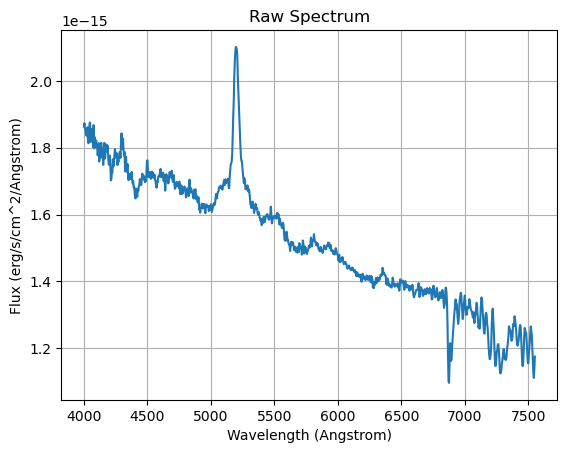

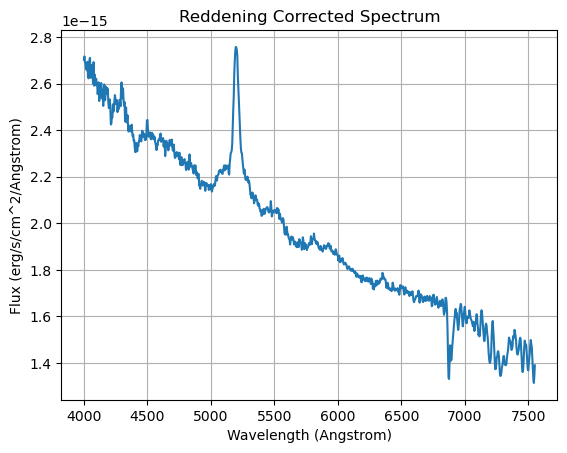

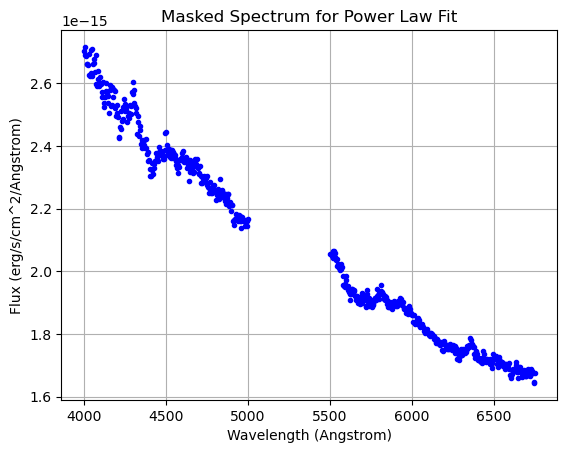

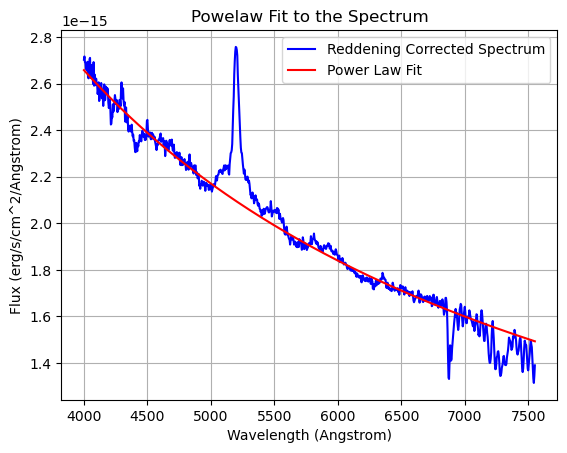

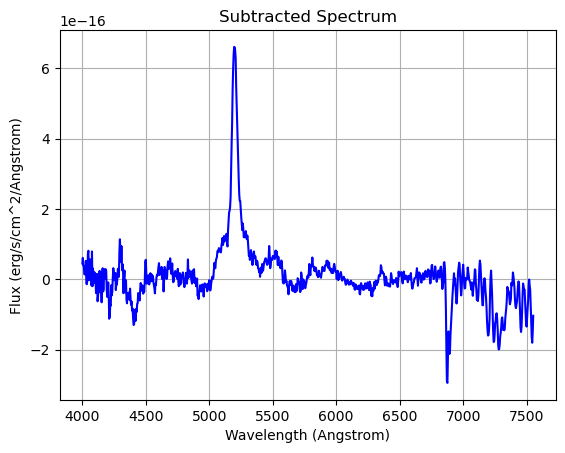

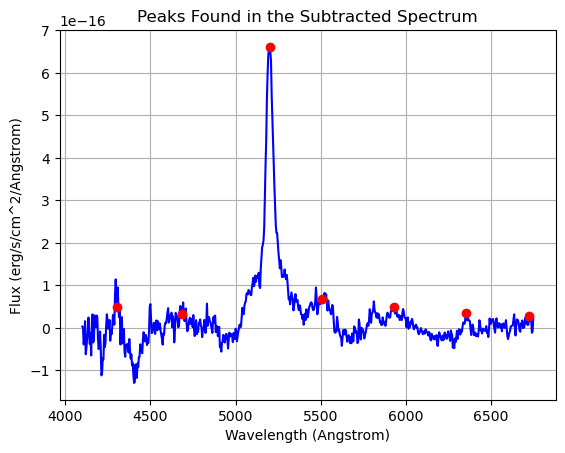

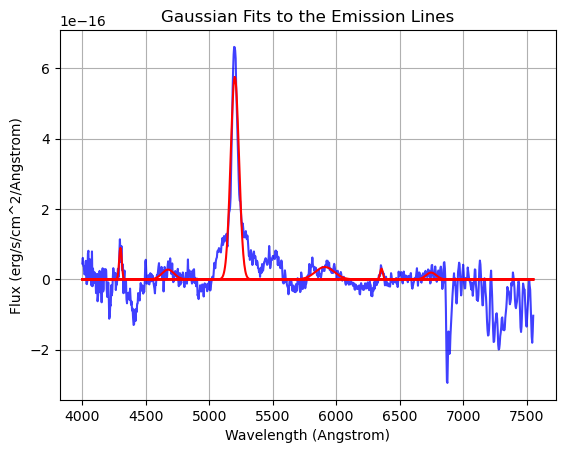

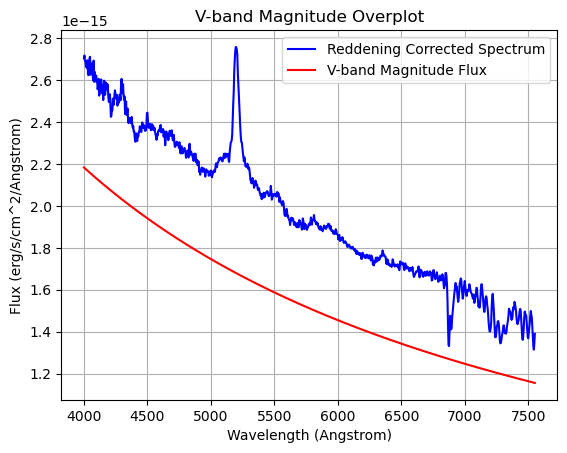

data.emission_lines=array([(4300.29845343, 10.25941102, 8.96714266e-17,  2147169.55630911,  33779.44254607,  0.92659388),
       (4675.11247207, 48.01380874, 2.77759089e-17,  9243077.70673199, 625969.25763562,  1.44896625),
       (5201.21909525, 32.75232158, 5.76074389e-16,  5667342.38335514, 235330.76020981, 22.58089728),
       (5909.92158187, 74.30380137, 3.52304192e-17, 11315449.84182561, 938130.90709994,  3.51767357),
       (6356.5882705 , 10.72703893, 3.08555665e-17,  1518791.94033122,  16901.15420124,  0.47515288),
       (6747.43812378, 40.33069722, 1.94206752e-17,  5379468.0040178 , 212030.5568896 ,  1.18691497)],
      dtype=[('mu', '<f8'), ('sigma', '<f8'), ('amp', '<f8'), ('doppler', '<f8'), ('thermal', '<f8'), ('eq_width', '<f8')])


In [2]:
path = '/run/media/sparsharay/groot/Codes/Workspace/Courses/PHY669_APM/project1/data/3c454.3/3c454.3_1.fc.spec_081029.fits'
data = sepecat(path, debug=True)
data.pipe()
data.overlay(v_band_mag=15.89)
print(f'{data.emission_lines=}')

## Histograms of the parameters derived from the strongest emission line of all the spectrum files in the directory

Rejecting /run/media/sparsharay/groot/Codes/Workspace/Courses/PHY669_APM/project1/data/3c454.3/3c454.3.fc.spec_081004.fits
Total files processed : 358


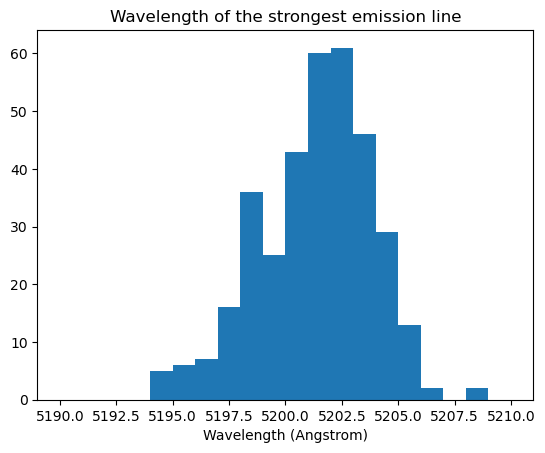

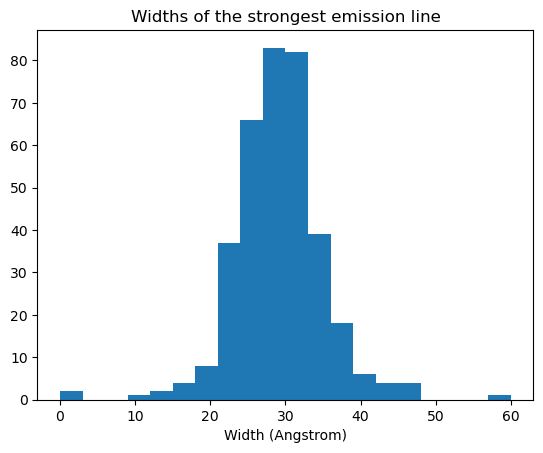

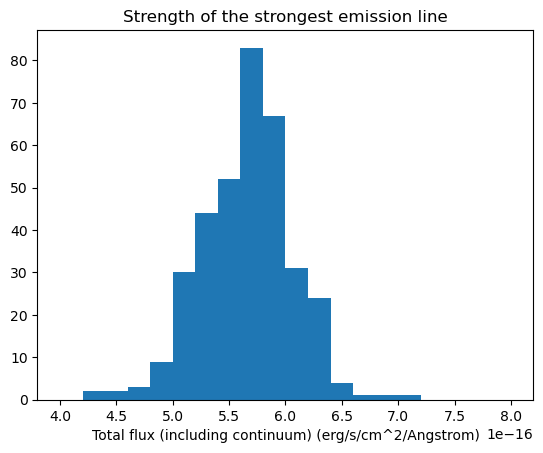

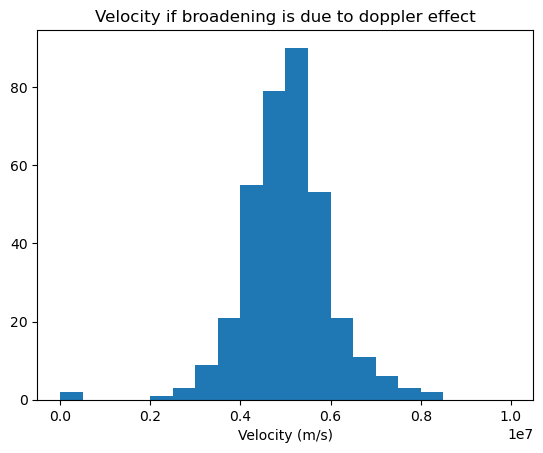

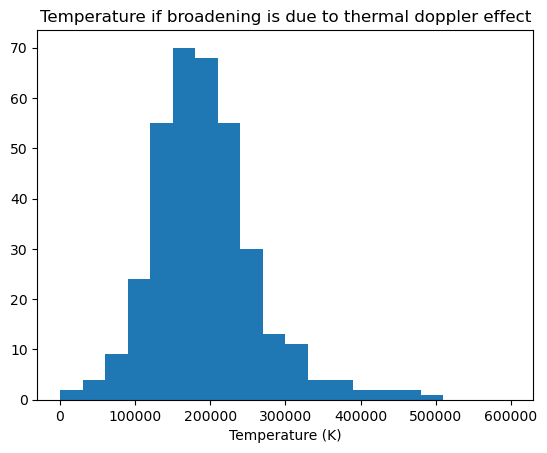

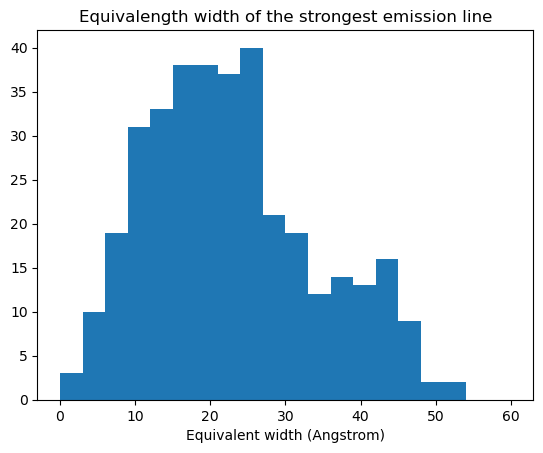

In [3]:
run_paths = glob('/run/media/sparsharay/groot/Codes/Workspace/Courses/PHY669_APM/project1/data/*')

spec_paths = []
for run_path in run_paths : spec_paths.extend(glob(run_path+'/3c454.3.fc.spec_*.fits')) # Source is 3c454.3

# print(spec_paths)

tot_mags = []
strongest_emissions = []
rejected_files = []

for spec_path in spec_paths : # iterate over all files found

    try : 
        spec = sepecat(spec_path)
        spec.pipe()
    except : 
        print(f'Rejecting {spec_path}')
        rejected_files.append(spec_path)
        continue

    # print(spec.fitc)

    tot_mags.append(spec.get_total_mag()) # To get the strongest and weakest spectrums

    emission_lines = spec.emission_lines
    strongest_emission = emission_lines[np.argmax(emission_lines[:]['amp'])] # Select the strongest emission line
    strongest_emissions.append(strongest_emission)

for rejected_file in rejected_files : spec_paths.remove(rejected_file)
print(f'Total files processed : {len(spec_paths)}')

strongest_emissions = np.array(strongest_emissions)
tot_mags = np.array(tot_mags)

# Plot the histograms

mus       = strongest_emissions[:]['mu']
sigmas    = strongest_emissions[:]['sigma']
amps      = strongest_emissions[:]['amp']
dopplers  = strongest_emissions[:]['doppler']
thermals  = strongest_emissions[:]['thermal']
eq_widths = strongest_emissions[:]['eq_width']

plt.hist(mus, range=(5190, 5210), bins=20)
plt.title('Wavelength of the strongest emission line')
plt.xlabel('Wavelength (Angstrom)')
plt.show()

plt.hist(sigmas, range=(0, 60), bins=20)
plt.title('Widths of the strongest emission line')
plt.xlabel('Width (Angstrom)')
plt.show()

plt.hist(amps, range=(4E-16, 8E-16), bins=20)
plt.title('Strength of the strongest emission line')
plt.xlabel('Total flux (including continuum) (erg/s/cm^2/Angstrom)')
plt.show()

plt.hist(dopplers, range=(0, 1E7), bins=20)
plt.title('Velocity if broadening is due to doppler effect')
plt.xlabel('Velocity (m/s)')
plt.show()

plt.hist(thermals, range=(0, 6E5), bins=20)
plt.title('Temperature if broadening is due to thermal doppler effect')
plt.xlabel('Temperature (K)')
plt.show()

plt.hist(eq_widths, range=(0, 60), bins=20)
plt.title('Equivalength width of the strongest emission line')
plt.xlabel('Equivalent width (Angstrom)')
plt.show()

## Plots from the subroutines processing the spec file with the weakest flux

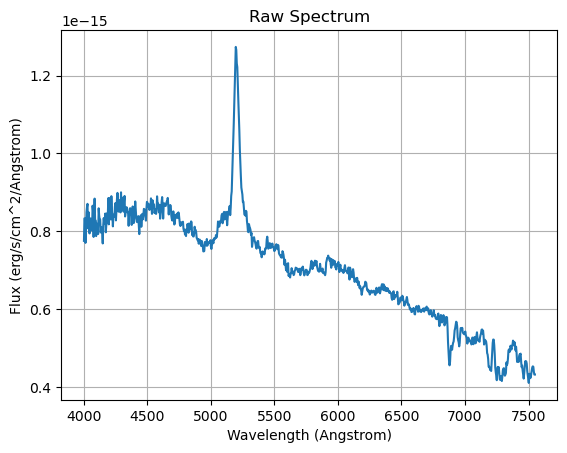

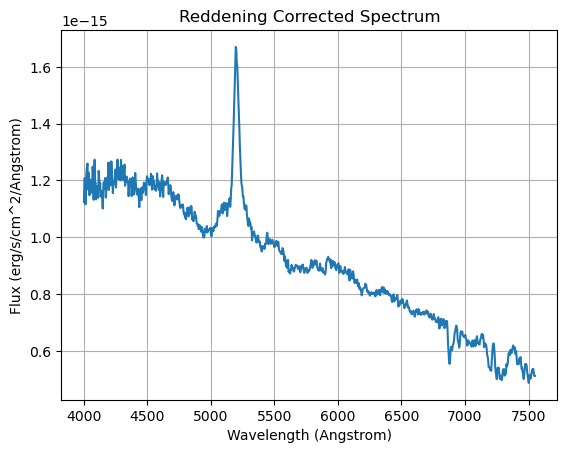

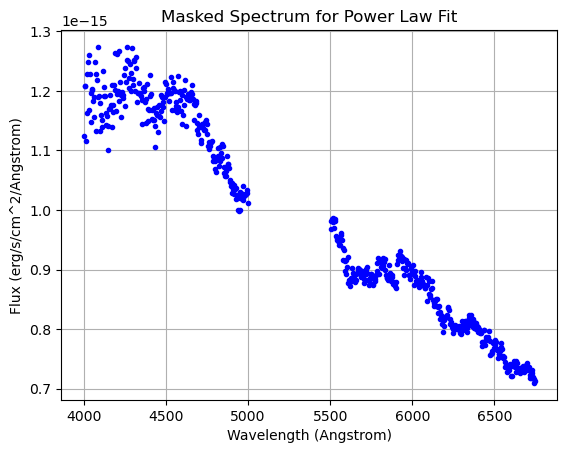

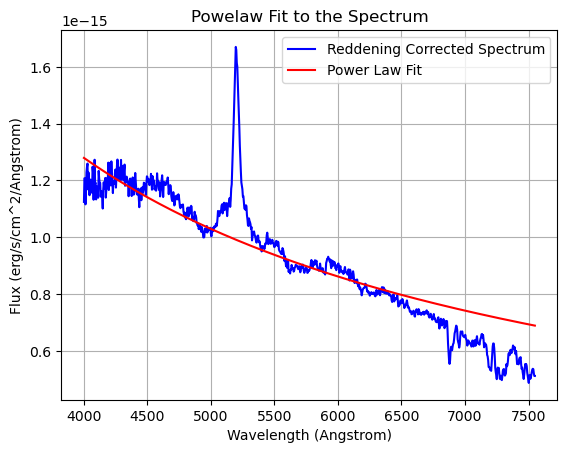

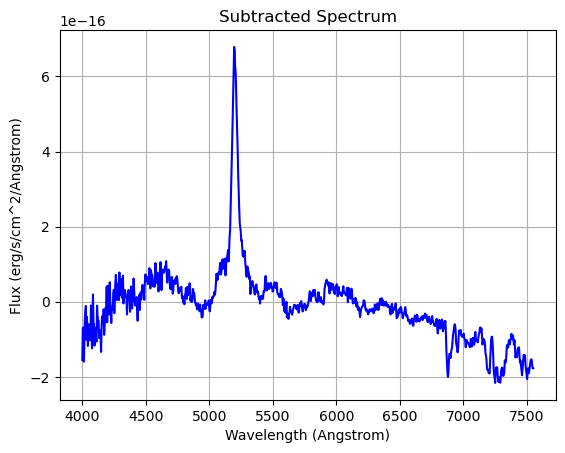

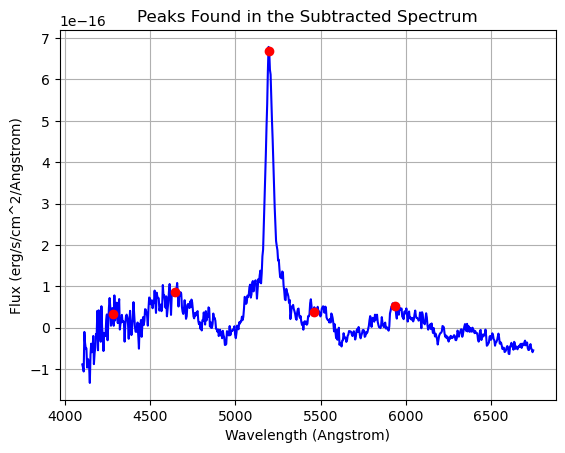

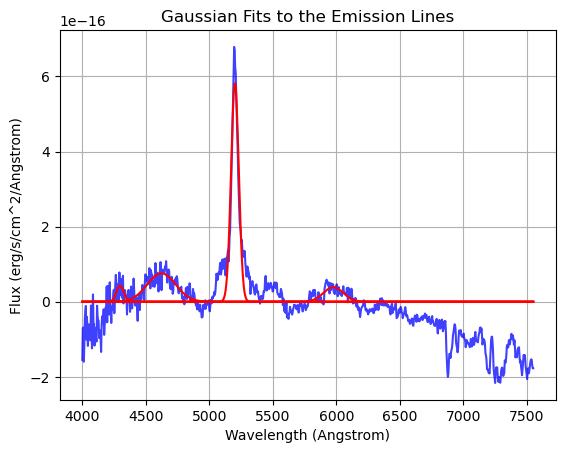

In [4]:
# Subroutine plots for the weakest spectrum
data = sepecat(spec_paths[np.argmin(tot_mags)], debug=True)
data.pipe()

## Plots from the subroutines processing the spec file with the strongest flux

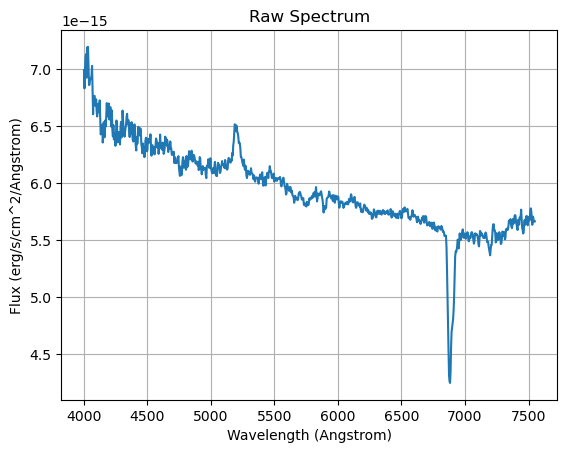

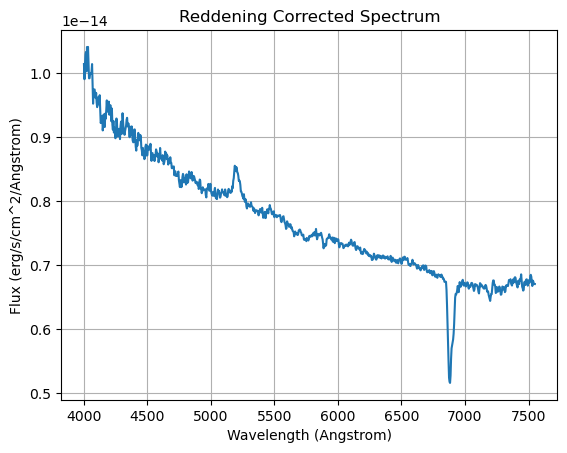

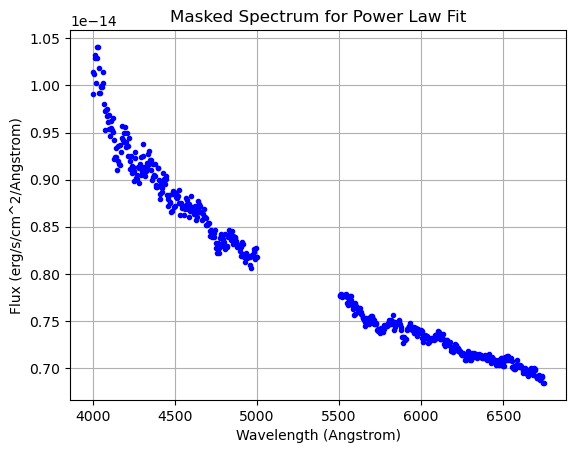

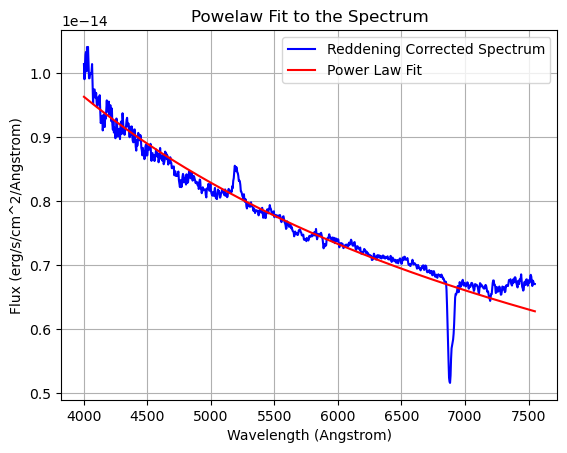

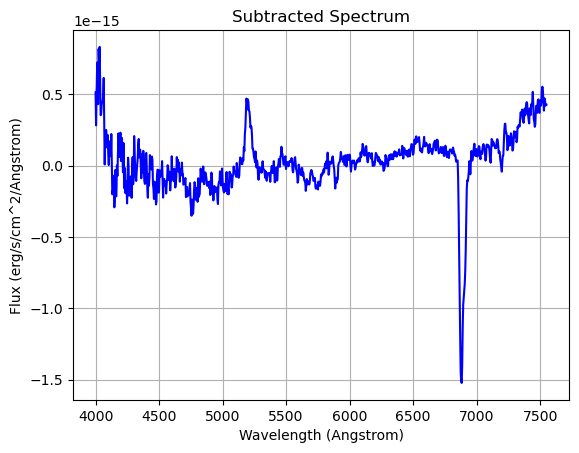

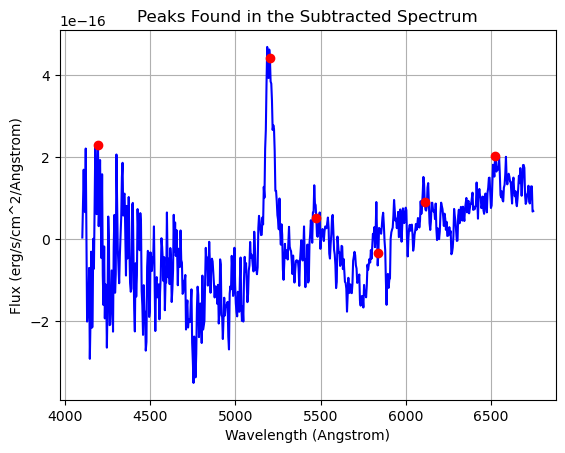

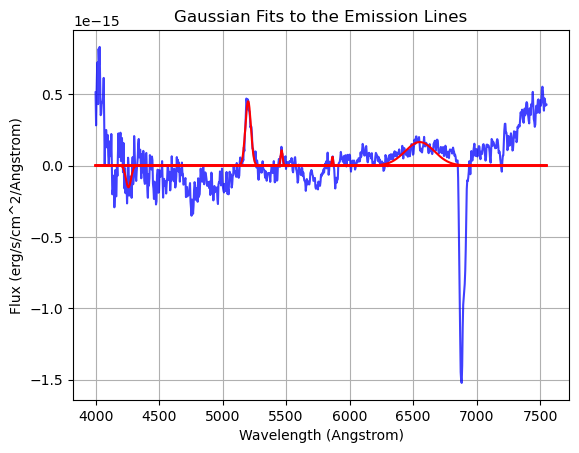

In [5]:
# Subroutine plots for the strongest spectrum
data = sepecat(spec_paths[np.argmax(tot_mags)], debug=True)
data.pipe()